# In this notebook I test different Word Embeddings

In [1]:
from google.colab import drive
#drive may already be mounted. allows access to drive data
drive.mount('/content/drive')
import torch
import gensim
import torch.nn as nn

Mounted at /content/drive


## First Embedding:

Colo-Ruiz cite this paper for an embedding: 

Pharmacovigilance from social media: 
mining adverse drug reaction mentions using sequence labeling with word embedding cluster features
https://academic.oup.com/jamia/article/22/3/671/776531

Embedding download:

http://diego.asu.edu/Publications/ADRMine.html



In [ ]:
#attempt to download thru bash command
#!gdown https://www.dropbox.com/s/xoi7xtj9yzl0o27/word_embeddings.txt && mv /content/word_embeddings.txt /content/drive/MyDrive/drugproject/2_scripts/embeddings

code below from: https://stackoverflow.com/questions/49710537/pytorch-gensim-how-to-load-pre-trained-word-embeddings

In [2]:
word_rep = gensim.models.KeyedVectors.load_word2vec_format('./drive/MyDrive/drugproject/2_scripts/embeddings/twitter_embeddings.txt')
weights = torch.FloatTensor(word_rep.vectors)

In [3]:
print("Words in vocab by Num of attributes:")
weights.shape

Words in vocab by Num of attributes:


torch.Size([26278, 150])

In [4]:
twitter_drug_Embedding = nn.Embedding.from_pretrained(weights)

## Second embedding

Running a MLP with the embedding. Adapted from Script *demonstration of slowness*

In [ ]:
SEED = 30255 # Specify a seed for reproducability
import random
import numpy as np
import torch
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(53113)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torch.utils.data.dataset import random_split
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from collections import Counter
from csv import reader
import time
import matplotlib.pyplot as plt
TRAIN_FILE = './drive/MyDrive/drugproject/3_data/train_all_data.csv'
TEST_FILE = './drive/MyDrive/drugproject/3_data/test_all_data.csv'
VALID_FILE = './drive/MyDrive/drugproject/3_data/valid_all_data.csv'

BATCH_SIZE = 64
SHUFFLE = True

cuda


In [ ]:
SENTIMENT_CATEGORIES = {
    "Negative":0,
    "Neutral":1,
    "Positive":2,
    "Postive": 2
}

In [ ]:
class DrugReviewDataset(Dataset):
    def __init__(self, csv_file, x_colname, target_colname):
        """
        the following are assumed about csv_file:
            - headers are in first row
            - there is a column called 'date'
            - there is a column called 'review' which contains the text data
        """
        self.x = []
        self.target = []
        with open(csv_file, 'r', encoding="utf8") as f:
            data = list(reader(f))

        target_colnum = data[0].index(target_colname)
        x_colnum = data[0].index(x_colname)
        for row in data[1:]:
            self.x.append(row[x_colnum])
            self.target.append(row[target_colnum])

        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        """
        idx can be a list or tensor if integers
        """
        example = (self.target[idx], self.x[idx])
        
        return example

def get_dataloader(data_file, batch_size, shuffle, collate=None, split=None,
                   train_sample=None, valid_sample=None):
    """
    datafile: path to input file (should be a csv)
    batch_size: (int) parameter for DataLoader class
    shuffle: (bool) parameter for DataLoader class
    collage: (fn) parameter for DataLoader class
    split: (bool) specifies if there is to be a train-validation split on data
    """

    ds = DrugReviewDataset(data_file, 'review', 'rating_category')
    # ds.target = target_name
    if split:
      train_dl = DataLoader(ds, batch_size=batch_size, shuffle=False, 
                              collate_fn=collate, sampler=train_sampler)  
      valid_dl = DataLoader(ds, batch_size=batch_size, shuffle=False, 
                              collate_fn=collate, sampler=valid_sampler)
      return train_dl, valid_dl
    
    dataloader = DataLoader(ds, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    
    return dataloader

In [ ]:
MAX_REVIEW_LEN = 250

def collate_fn(batch):
    word_idxs = []
    labels = []
    for example in batch:
      example_idxs = []
      label, review = example
      labels.append(SENTIMENT_CATEGORIES[label])
      for idx, token in enumerate(tokenizer(review)):
        if idx == MAX_REVIEW_LEN:
          break
        example_idxs.append(vocab_reviews[token])
      word_idxs.append(example_idxs)
    word_idxs = torch.tensor([batch + (MAX_REVIEW_LEN - len(batch))*[0] for batch in word_idxs])
    labels = torch.tensor(labels)

    return labels.to(device), word_idxs.to(device)

In [ ]:
train_dataloader = get_dataloader(TRAIN_FILE, BATCH_SIZE, SHUFFLE, collate_fn)
test_dataloader = get_dataloader(TEST_FILE, BATCH_SIZE, SHUFFLE, collate_fn)
valid_dataloader = get_dataloader(VALID_FILE, BATCH_SIZE, SHUFFLE, collate_fn)

('Positive', "I've been using Otrexup for several  months now, increasing from a 10mg injection to a 20mg. I have had severe leg cramps in my thigh muscles since beginning this drug. However, I was injecting into the same leg and then leg(s) so maybe I will try the stomach. I am also on Rituxin infusions. These drugs have turned my health around; my RA is now manageable.")


In [ ]:
import torch.nn.functional as F
from torch.nn import Dropout

class BoWModel(nn.Module):

    def __init__(self, num_labels, vocab_size, embedding_dim, max_tokens,
                 hidden_layer_size, activation_function, embedding, dropout=True):
        
        super(BoWModel, self).__init__()
        
        self.embedding = embedding
        self.top_layer = nn.Linear(max_tokens*embedding_dim, hidden_layer_size)
        self.hidden_layer = nn.Linear(hidden_layer_size, num_labels)
        self.activation_function = activation_function
        if dropout: self.drop = Dropout()

    def forward(self, bow_vec, dropout=True):

        x_embed = self.embedding(bow_vec)
        mats, rows, cols = x_embed.shape
        concat_x = x_embed.reshape(mats, rows*cols)
        out0 = self.top_layer(concat_x)
        h0 = self.activation_function(out0)
        y = self.hidden_layer(h0)
        if dropout: y = self.drop(y)

        return F.log_softmax(y, dim=1)

loss_function = torch.nn.CrossEntropyLoss() 

def train_an_epoch(optimizer, model, dataloader, loss_function=loss_function):
    model.train()
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')


def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model.forward(word_idxs)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
_, embedding_dim = weights.shape

In [ ]:
model = BoWModel(
    num_labels=3,
    vocab_size=len(vocab_reviews),
    embedding_dim=embedding_dim,
    hidden_layer_size=256,
    embedding=twitter_drug_Embedding,
    activation_function=nn.Tanh(),
    max_tokens=MAX_REVIEW_LEN
).to(device)

In [ ]:
%matplotlib inline

EPOCHS = 15
optimizer = optim.Adam(model.parameters(), lr=1e-6)


valid_accuracies=[]
test_accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(optimizer, model, train_dataloader)
    accuracy = get_accuracy(model, valid_dataloader)
    valid_accuracies.append(accuracy)
    test_accuracy = get_accuracy(model, test_dataloader)
    print("Test set accuracy is:{}".format(test_accuracy))
    test_accuracies.append(test_accuracy)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}.')

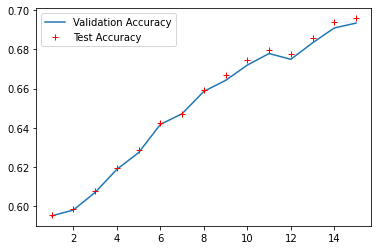

In [ ]:
plt.plot(range(1, EPOCHS+1), valid_accuracies, label='Validation Accuracy')
plt.plot(range(1, EPOCHS+1), test_accuracies, "r+", label='Test Accuracy')
plt.legend()
plt.show()